# Benchmark on OGB, https://ogb.stanford.edu/docs/home/

In [3]:
import importlib
import random
import argparse
import configparser
import numpy as np
import networkx as nx
from collections import defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_sparse
from torch import Tensor
from torch.nn import Linear
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
import torch.optim as optim

from torch_geometric.utils import negative_sampling, to_networkx
from typing import Union, Tuple
from torch_geometric.typing import OptPairTensor, Adj, OptTensor, Size
from torch_sparse import SparseTensor, matmul
from torch_geometric.nn.conv import MessagePassing

from ogb.linkproppred import PygLinkPropPredDataset, Evaluator


import networkx as nx
import seaborn as sns
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

import scipy
import math


from dataset_utils import node_feature_utils
from dataset_utils.node_feature_utils import *
import my_utils as utils

importlib.reload(utils)

load node feauture: ENZYMES_degree_dist_shuffled.npy

load node feauture: COLLAB_degree_dist_shuffled.npy

load node feauture: NCI1_degree_dist_shuffled.npy

load node feauture: IMDB-MULTI_degree_dist_shuffled.npy



<module 'my_utils' from '/li_zhengdao/github/GenerativeGNN/my_utils.py'>

In [4]:

class MyIter(object):
    def __init__(self, ite_obj) -> None:
        self.ite_obj = ite_obj
        self.ite = None
        
    def __iter__(self):
        self.ite = iter(self.ite_obj)
        return self.ite
    
    def __next__(self):
        if self.ite is None:
            self.__reset__()
        try:
            res = next(self.ite)
            return res
        except StopIteration as e:
            self.__reset__()
            
        return next(self.ite)
    
    def __reset__(self):
        self.ite = iter(self.ite_obj)
    
    
l= [ 1, 2, 3]
a = MyIter(l)

for i in range(10):
    print(a.__next__())
    


1
2
3
1
2
3
1
2
3
1


In [3]:
sample_dist = [3,3,3,2,2,2,1,1,1,1,1,1,1,1]
node_fea = np.random.choice(sample_dist, size=100).__iter__()
print(len(node_fea))



TypeError: object of type 'iterator' has no len()

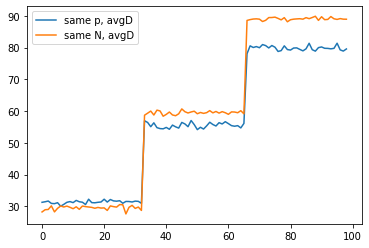

In [4]:
plt.figure()
ss = []
dd = []

each_num = 33
for i in list(range(80, 80+2*60+1, 60)):
    # NOTE: class1 N = 80, p=0.4, avgD = 30, 
    # NOTE: class2 N = 140, p=0.4, avgD = 50,
    # NOTE: class3 N = 200, p=0.4, avgD = 80, 
    for _ in range(each_num):
        g = nx.erdos_renyi_graph(i, 0.4)
        stats = graph_stats_degree(adj=nx.to_numpy_array(g))
        ss.append(stats)

for i in list(np.arange(0.3, 1, 0.3)):
    # NOTE: class1 N = 100, p=0.3, avgD = 30,
    # NOTE: class2 N = 100, p=0.6, avgD = 50,
    # NOTE: class3 N = 100, p=0.9, avgD = 80, 
    for _ in range(each_num):
        g = nx.erdos_renyi_graph(100, i)
        stats = graph_stats_degree(adj=nx.to_numpy_array(g))
        dd.append(stats)
    
ss = np.stack(ss, axis=0)
dd = np.stack(dd, axis=0)
plt.plot(ss[:, 0],label='same p, avgD')
plt.plot(dd[:, 0],label='same N, avgD')
# plt.plot(ss[:, 2], label='totalD')
plt.legend()
plt.show()


findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


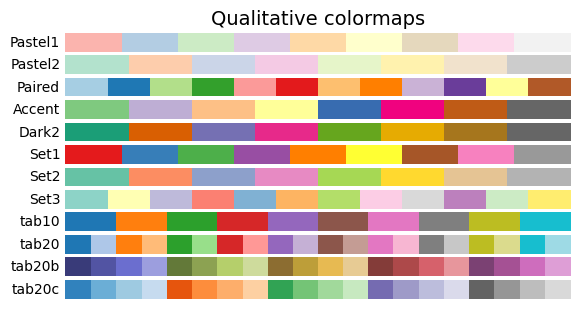

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm


# here..
cmaps = {}

gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))


x_y_label_font = 20
x_y_legend_font = 20

plt.rc('font', family='Times New Roman')
fig_dpi = 220
fig_shape_squre = (6, 5)

def plot_color_gradients(category, cmap_list):
    # Create figure and adjust figure height to number of colormaps
    nrows = len(cmap_list)
    figh = 0.35 + 0.15 + (nrows + (nrows - 1) * 0.1) * 0.22
    fig, axs = plt.subplots(nrows=nrows + 1, figsize=(6.4, figh), dpi=100)
    fig.subplots_adjust(top=1 - 0.35 / figh, bottom=0.15 / figh,
                        left=0.2, right=0.99)
    axs[0].set_title(f'{category} colormaps', fontsize=14)

    for ax, name in zip(axs, cmap_list):
        ax.imshow(gradient, aspect='auto', cmap=plt.get_cmap(name))
        ax.text(-0.01, 0.5, name, va='center', ha='right', fontsize=10,
                transform=ax.transAxes)

    # Turn off *all* ticks & spines, not just the ones with colormaps.
    for ax in axs:
        ax.set_axis_off()

    # Save colormap list for later.
    cmaps[category] = cmap_list
    plt.show()

class MyColor(object):
    def __init__(self, cmap_name='tab10', skip_idx=5, backup_name='Set1', backup_color=3):
        self.color_set  = plt.get_cmap(cmap_name).colors
        self.backup_set = plt.get_cmap(backup_name).colors
        self.backup_color = backup_color
        self.skip_idx=skip_idx
        self.idx = 0
        self.color_len = len(self.color_set)
        
    def get_color(self, by_id=None):
        if by_id is not None:
            return self.color_set[by_id]
        
        if self.idx == self.color_len - 1:
            self.idx = 0
        if self.idx == self.skip_idx:
            self.idx += 1
            return self.backup_set[self.backup_color]
        color = self.color_set[self.idx]
        self.idx += 1
        return color
    

plot_color_gradients('Qualitative',
                     ['Pastel1', 'Pastel2', 'Paired', 'Accent', 'Dark2',
                      'Set1', 'Set2', 'Set3', 'tab10', 'tab20', 'tab20b',
                      'tab20c'])

# TODO: 0918. For all benchmark datasets.
* check the correlation between degree and CC 
* or $|C_k|$, $k>3$
* Why related to training difficulty? because that GNN cannot learn them.
* Why cannot learn? computational graphs are the same and is bounded by k-WL-test.
* So requires additional information of subgraphs, but $O(kN)$ complexity.
* so sampling may be a good choice.
* may use DP to sample.

* based on above figure, pick same horizontal points
- blueK=0.2, p=0.3, orangeK=0.25, p=0.35, greenK=0.3, p= 0.6,
- redK=0.35,p=0.6, orangek=0.25, p=0.3 (try this first)

# Generate WS graph node feature

# construct node clustring coefficient label

# Generate WS graph dataloader

# CCA (Canical Component Analysis)

# Check whether GNN can learn the CC ?

# generate CC historgram with same degree
# cc without degree correlation bias



# load OGB dataset:

In [12]:
from matplotlib import ticker
import numpy as np
from matplotlib.pyplot import MultipleLocator


x_y_label_font = 5
x_y_legend_font = 5


def plot_bars(X, y, y_err=None, legend_pos=None, label="None", ax=None, colors=None, width=0.1):
    color = 'black'
    err_attr={"elinewidth":2,"ecolor":"black","capsize":6}
    if colors is None:
         colors = ['#F9DA4A','#96DB35', '#66C2A5','#81B0D3','#EF8C61']
         
    # ax.bar(X, y, yerr=y_err, error_kw=err_attr, color = colors,
    #         width=width, label=label)
    ax.bar(X, y, color = colors,
             width=width, tick_label=label)
    
    ax.set_ylabel('Correlation', color=color, fontsize=x_y_label_font)
    
     # fontsize=15, fontweight='bold')
    ax.tick_params(axis='y', labelcolor=color, labelsize=x_y_label_font)
    ax.tick_params(axis='x', rotation=70, labelsize=x_y_label_font)
    # plt.xticks(rotation=180)
    
    # ax.tick_params(axis='x)
    # ax.legend([logit.m1], prop={'size': 15}, labelspacing=0.1)
#     ax.set_title(label, fontsize=x_y_label_font)
    # plt.rcParams['xtick.direction'] = 'in'



In [ ]:
# test bar:
xxx = np.linspace(0, 1, num=3)
fig, axess = plt.subplots(1, 2)

plot_bars(xxx, [1,-1,2], ax=axess[0])
plot_bars(xxx, [1,-1,2], ax=axess[1])
plt.show()



In [ ]:
import my_utils as utils
importlib.reload(utils)

import networkx as nx
from functools import reduce
import models
importlib.reload(models)


def graphs_statistics(adjs:list, labels:list):
    
    statistics = []
    for i, A in enumerate(adjs):
        nx_g = nx.from_numpy_array(A)
        avg_cc = nx.average_clustering(nx_g)
        degree_set = node_feature_utils.node_degree_feature(adj=A)
        avg_degree = np.mean(degree_set).item()
        tris = np.mean(node_feature_utils.node_tri_cycles_feature(adj=A)).item()
        cycles = nx.cycle_basis(nx_g)
        N = A.shape[0]
        minD = np.min(degree_set)
        maxD = np.max(degree_set)
        statistics.append((N, avg_cc, avg_degree, tris, cycles, labels[i], minD, maxD))
    
    return statistics


def plot_cyc_degree_corr(title:str, statistics_sorted:list, data_labels:tuple, axe=None, 
                           sort_idx=None, show_idx:list=None, anchor:int=None,corrs_type='MIC', need_filter=True):
    # NOTE: Sorted by other index
    if sort_idx is not None:
        statistics_sorted = sorted(statistics_sorted, key=lambda x: x[sort_idx])
        
    if need_filter:
        # TODO: Filter cycles and degree outliers, abs(z-score) > 3.
        statistics_sorted_filtered = []
        for i in statistics_sorted:
            # NOTE: filter any outliers:
            need_filter = False
            for l in range(len(i)):
                if i[l] < -3 or i[l] > 3 or i[l] < -3 or i[l] > 3:
                    need_filter = True
                    break
                
            if need_filter:
                continue
            
            statistics_sorted_filtered.append(i)
        
        statistics_sorted = statistics_sorted_filtered
        
    # TODO: Get correlation:
    corrs = utils.get_corrs(statistics_sorted, cate='all')

    if axe is None:
        fig = plt.figure()
        axe = plt.gca()
        
    axe.set_title(title)
    
    if show_idx is None:
        show_idx = list(range(len(statistics_sorted[0])))
    print('corrs shape', corrs[corrs_type].shape)
    X = np.linspace(0, 1, len(show_idx))
    y = np.array([np.abs(corrs[corrs_type][id, anchor]) for id in show_idx])
    color = MyColor('Accent', skip_idx=3, backup_name='Set1', backup_color=7)
    colors = [color.get_color() for _ in show_idx]
    legends = [data_labels[i] for i in show_idx]
    plot_bars(X, y,label=legends, ax=axe, colors=colors)
    
    
def plot_graphs_statistics(title:str, statistics_sorted:list, data_labels:tuple, axe=None, 
                           sort_idx=None, show_idx:list=None, plot_corr_bar=False, need_filter=True):
    from matplotlib import lines
    line_styles = list(lines.lineStyles.keys())
    def get_style(next_id):
        if next_id < 0:
            next_id += len(line_styles)
        return line_styles[next_id%len(line_styles)]
    
    colors = MyColor()
    
    if not isinstance(statistics_sorted, list):
        statistics_sorted = [i for i in statistics_sorted]
        
    print(statistics_sorted[0].shape)
    # NOTE: Sorted by other index
    if sort_idx is not None:
        statistics_sorted = sorted(statistics_sorted, key=lambda x: x[sort_idx])
        
    # TODO: Filter cycles and degree outliers, abs(z-score) > 3.
    if need_filter:
        statistics_sorted_filtered = []
        for i in statistics_sorted:
            # NOTE: filter any outliers:
            need_filter = False
            for l in range(len(i)-2):
                
                # TODO: only filter normlized data:
                if i[l] < -3 or i[l] > 3 or i[l] < -3 or i[l] > 3:
                    need_filter = True
                    break
            if need_filter:
                continue
            
            statistics_sorted_filtered.append(i)
        
        statistics_sorted = statistics_sorted_filtered
    # TODO: Get correlation:
    # corrs = utils.get_corrs(statistics_sorted, cate='all')
    
    if plot_corr_bar:
        axe.set_title(title)
        axe.plot_bar
    
    if axe is not None:
        # MIC_corr = f"M(dc)={round(corrs['MIC'][1, -2], 2)}, M(dy)={round(corrs['MIC'][1, -1], 2)}," \
                    #  + f" M(cy)={round(corrs['MIC'][-2, -1], 2)}"
        # axe.set_title(title+f"\n C(dc)={round(corrs['pearson'][1, -2], 2)}, C(dy)={round(corrs['pearson'][1, -1], 2)}," \
                    #  + f" C(cy)={round(corrs['pearson'][-2, -1], 2)}\n{MIC_corr}")
        axe.set_title(title)
        # NOTE: C: correlation, d:degree, c: cycles, y:labels of samples.
        
        
        if show_idx is None:
            show_idx = list(range(len(statistics_sorted[0])))
        
        
        for sid in show_idx:
            # TODO: color?
            axe.plot([i[sid] for i in statistics_sorted], label=data_labels[sid], 
                     linestyle=get_style(sid), color=colors.get_color())
            
    else:
        plt.figure()
        plt.title(title)
        if show_idx is None:
            show_idx = list(range(len(statistics_sorted[0])))
            
        print('avgD/N', statistics_sorted[0][4])
        
        for id in show_idx:
            plt.plot([i[id] for i in statistics_sorted], label=data_labels[id], color=colors.get_color())
        
        plt.legend()
        plt.show()


def plot_cc_degree_distribution(cc_degree_graphs, cc_degree_y, g_label='train'):
    
    # random add edges:
    # add E edges, repeat for 5 times.
    print(type(cc_degree_graphs[0].todense()))

    data_graphs = [(cc_degree_y[i],np.mean(np.sum(cc_degree_graphs[i].todense(), axis=1)), np.mean(node_feature_utils.node_tri_cycles_feature(adj=cc_degree_graphs[i])).item(), i) for i in range(len(cc_degree_graphs))]

    data_graphs_s_train = sorted(data_graphs, key=lambda x: x[0])

    ccs = [d[0] for d in data_graphs_s_train]
    degrees = [d[1]/10 for d in data_graphs_s_train]
    tri_cycles = [d[2]/4 for d in data_graphs_s_train]

    plt.figure()
    plt.title(g_label)
    plt.plot(ccs, label='labels')
    plt.plot(degrees, label='degree',  linestyle='--')
    plt.plot(tri_cycles, label='tri_cycles', linestyle='-.')
    plt.legend()
    plt.show()
    
    

# Try Real-world dataset from PyG generic datasets
website: `https://pytorch-geometric.readthedocs.io/en/latest/notes/data_cheatsheet.html`

* graph classification:
    * TUDataset
    * ZINC

## TODO: 
1. use. # due: 6.30.
2. profile. # due: 7.1.

## TODO (2022.09.24):
* 1. load from gnn-comparison module.
* 2. check the avg.CC avg.Degree and performance associations.

In [ ]:
# Load all datasets:

import sys,os
sys.path.append(os.getcwd())


import my_utils

from PrepareDatasets import DATASETS

import dataset_utils
print(DATASETS.keys())

datasets_obj = {}
for k, v in DATASETS.items():
    print('dataset name:', k)
    dat = v()
    datasets_obj[k] = dat
    print(type(dat.dataset.get_data()))


In [3]:
# Load specific dataset:

import sys,os
sys.path.append(os.getcwd())


from PrepareDatasets import DATASETS
import my_utils
import dataset_utils


print(DATASETS.keys())
"""
    'REDDIT-BINARY': RedditBinary,
    'REDDIT-MULTI-5K': Reddit5K,
    'COLLAB': Collab,
    'IMDB-BINARY': IMDBBinary,
    'IMDB-MULTI': IMDBMulti,
    'NCI1': NCI1,
    'ENZYMES': Enzymes,
    'PROTEINS': Proteins,
    'DD': DD,
    "MUTAG": Mutag,
    'CSL': CSL
"""

data_names = ['IMDB-BINARY']
data_names = ['PROTEINS', 'DD']
data_names = ['ENZYMES', 'NCI1']
data_names = ['COLLAB', 'IMDB-MULTI']
datasets_obj = {}
for k, v in DATASETS.items():
    if k not in data_names:
        continue
    
    print('loaded dataset, name:', k)
    dat = v(use_node_attrs=True, DATA_DIR='./DATA')
    datasets_obj[k] = dat
    print(type(dat.dataset.get_data()))

dict_keys(['REDDIT-BINARY', 'REDDIT-MULTI-5K', 'COLLAB', 'IMDB-BINARY', 'IMDB-MULTI', 'NCI1', 'ENZYMES', 'PROTEINS', 'DD', 'MUTAG', 'CSL'])
loaded dataset, name: COLLAB
processed_dir:  DATA/COLLAB/processed
load dataset !
dataset len:  5000
load splits: DATA/COLLAB/processed/COLLAB_splits.json
split counts: 10
<class 'list'>
loaded dataset, name: IMDB-MULTI
processed_dir:  DATA/IMDB-MULTI/processed
load dataset !
dataset len:  1500
load splits: DATA/IMDB-MULTI/processed/IMDB-MULTI_splits.json
split counts: 10
<class 'list'>


In [3]:
datasets_obj['IMDB-BINARY'].dataset.get_data()[0]

Data(N=20, edge_index=[2, 146], x=[20, 0], y=[1])

In [6]:

def get_pyg_dataset_stats(pyg_data):
    adjs = []
    # TODO: transform into networkx.
    labels = []
    for graph in pyg_data.dataset.get_data():
        row = graph.edge_index[0]
        col = graph.edge_index[1]
        graph.y
        N = graph.x.shape[0]
        dense_A = torch.zeros((N, N))
        dense_A[row, col] = 1
        A = dense_A.detach().numpy()
        adjs.append(A)
        labels.append(graph.y.item())
    return graphs_statistics(adjs, labels)


# print(node_feature_utils.node_cc_avg_feature(adj=dense_A.detach().numpy()))

In [5]:
cds_mutag = np.load('mutag_degree_dist.npy').__iter__()
print(cds_mutag.__next__().item())
print(cds_mutag.__next__().item())
print(cds_mutag.__next__().item())
print(cds_mutag.__next__().item())
print(cds_mutag.__next__().item())
print(cds_mutag.__next__().item())
print(cds_mutag.__next__().item())

NameError: name 'np' is not defined

In [4]:


# generate node degree feature:
import dataset_utils.node_feature_utils as nfu
# TODO: check shuffle func:

def shuffle2(data, data_name):
    node_num_total = 0
    node_index = {}
    start_id = 0
    copy_degree_sequence = []
    for i, d in enumerate(data):
        node_num = d.x.shape[0]
        node_num_total += node_num
        for j in range(node_num):
            node_index[start_id] = (i, j)
            start_id += 1
            copy_degree_sequence.append(d.x[j].item())
    
    # dump copy_degree_sequece:
    cds = np.array(copy_degree_sequence)
    print('max csd:', np.max(cds))
    np.save(f'{data_name}_degree_dist.npy', cds)
    print(f'dumped {data_name}_degree_dist.npy!!!')
    
    np.random.shuffle(copy_degree_sequence)
    cds_shuffle = np.array(copy_degree_sequence)
    print('cds_shuffle max 10000 csd:', np.max(cds_shuffle))

    np.save(f'{data_name}_degree_dist_shuffled.npy', cds_shuffle)
    print(f'dumped {data_name}_degree_dist_shuffled.npy!!!')
    
    shuf_idx = list(np.arange(node_num_total))
    pre_value = data[0].x
    sample_ids = [s for s in np.random.choice(shuf_idx, size=node_num_total, replace=True)].__iter__()
    # sample_ids = np.random.randint(1, int(4), size=len(shuf_idx)).__iter__()
    
    for d in data:
        new_x = []
        N = d.x.shape[0]
        for i in range(N):
            new_x.append(copy_degree_sequence[sample_ids.__next__().item()])
            
        d.x = np.array(new_x).reshape(N, 1)
        
def shuffle(data):
    node_num_total = 0
    node_index = {}
    start_id = 0
    for i, d in enumerate(data):
        node_num = d.x.shape[0]
        node_num_total += node_num
        for j in range(node_num):
            node_index[start_id] = (i, j)
            start_id += 1
            
    shuf_idx = list(np.arange(node_num_total))
    np.random.shuffle(shuf_idx)
    np.random.shuffle(shuf_idx)
    np.random.shuffle(shuf_idx)
    # construct pairs
    pairs = []
    for i in range(0, len(shuf_idx), 2):
        if i + 1 < len(shuf_idx):
            pairs.append((shuf_idx[i], shuf_idx[i+1]))

    print(f'shuffle feature!, total len: {node_num_total}, pair len: {len(pairs)}')
    # reconstruct:
    for (p1, p2) in pairs:
        # swich p1 p2 in place
        p1_node, p1_x_id = node_index[p1]
        p2_node, p2_x_id = node_index[p2]
        tmp = data[p1_node].x[p1_x_id]
        data[p1_node].x[p1_x_id] = data[p2_node].x[p2_x_id]
        data[p2_node].x[p2_x_id] = tmp
        
        if p1_node == 3 or p2_node == 3:
            print('node 1:', p1_node, p1_x_id, ' to node2:', p2_node, p2_x_id)
        
        
def plot_st(cur_fea):
    
    max_dd = [s[0] for s in cur_fea]
    min_dd = [s[1] for s in cur_fea]
    mean_dd = [s[2] for s in cur_fea]
    
    plt.figure()
    plt.plot(max_dd)
    plt.plot(min_dd)
    plt.plot(mean_dd)
    plt.ylim(0, 3.1)
    plt.show()
   

# normalize:
# print(data[0].x)
# node_degree_fea = my_utils.normalize(
#             node_degree_fea, along_axis=-1, same_data_shape=False)

# node_randid_fea = my_utils.normalize(
#             node_randid_fea, along_axis=-1, same_data_shape=False)

# node_guass_fea = my_utils.normalize(
#             node_guass_fea, along_axis=-1, same_data_shape=False)



# # plot original degree dist:
# dd = [(np.max(n),np.min(n), np.mean(n)) for n in node_degree_fea]
# plot_st(dd)

# # plot shuffled degree dist:
# # # # get shuffle feature:
# node_degree_shuffle = [d.x for d in data]
# dd_shuf = [(np.max(n),np.min(n), np.mean(n)) for n in node_degree_shuffle]
# plot_st(dd_shuf)

# # plot rand id dist:
# randfea = [(np.max(n),np.min(n), np.mean(n)) for n in node_randid_fea]
# plot_st(randfea)

# # plot guass dist:
# gaussfea = [(np.max(n),np.min(n), np.mean(n)) for n in node_guass_fea]
# plot_st(gaussfea)

# sort:

# dd = sorted(dd, key=lambda x:x[0])

# d_fea = np.concatenate(node_degree_fea, axis=0)

# print(d_fea.shape)

# plt.figure()
# plt.hist(d_fea[:, 0], 100, density=False, facecolor='g', alpha=0.75)
# plt.xlabel('degree')
# plt.ylabel('node amount')
# plt.show()

# TODO: assign node feature from samples from shuffled original degree set.


In [5]:
import importlib

importlib.reload(nfu)



def dump_shuffled_data(data_name):
    data = datasets_obj[data_name].dataset.get_data()
    for g in data:
        adj = g.to_numpy_array()
        g.x = nfu.node_degree_feature(adj=adj, checkpoint=False)

    shuffle2(data, data_name=data_name)

In [12]:
# data_names = ['ENZYMES', 'NCI1']

dump_shuffled_data(data_names[0])
dump_shuffled_data(data_names[1])

max 10000 csd: 9.0
dumped ENZYMES_degree_dist.npy!!!
cds_shuffle max 10000 csd: 9.0
dumped ENZYMES_degree_dist_shuffled.npy!!!
max 10000 csd: 4.0
dumped NCI1_degree_dist.npy!!!
cds_shuffle max 10000 csd: 4.0
dumped NCI1_degree_dist_shuffled.npy!!!


In [6]:
# data_names = ['COLLAB', 'IMDB-MULTI']

dump_shuffled_data(data_names[0])
dump_shuffled_data(data_names[1])

max csd: 491.0
dumped COLLAB_degree_dist.npy!!!
cds_shuffle max 10000 csd: 491.0
dumped COLLAB_degree_dist_shuffled.npy!!!
max csd: 88.0
dumped IMDB-MULTI_degree_dist.npy!!!
cds_shuffle max 10000 csd: 88.0
dumped IMDB-MULTI_degree_dist_shuffled.npy!!!


# -------------------------- plot degree distribution

In [ ]:
# plot as the previous sequence:
# generate node degree feature:
import dataset_utils.node_feature_utils as nfu

node_degree_fea = [g.x for g in data]

dd = []
for n in node_degree_fea:
    dd.append((np.max(n),np.min(n)))
# sort:
sdd = sorted(dd, key=lambda x:x[0])
max_dd = [s[0] for s in sdd]
min_dd = [s[1] for s in sdd]

plt.figure()
plt.plot(max_dd)
plt.plot(min_dd)
plt.show()

# conclusion: shuffle works ok !!!!

In [ ]:
# TODO: show ego network in IMDB-B
adj = datasets_obj['IMDB-BINARY'].dataset.get_data()[555].to_numpy_array()
print(adj.shape)
# meaningless.
# all are complete graph.
g = nx.from_numpy_array(adj)
nx.draw(g)

In [ ]:
# TODO: plot on one figure:
datasets_stats = {}
for k, v in datasets_obj.items():
    datasets_stats[k] = get_pyg_dataset_stats(v)

# visualize MUTAG

In [ ]:
def generate_node_colors(node_labels_onehot):
    idx = torch.argmax(node_labels_onehot, dim=1)
    color = MyColor()
    colors = [color.get_color(i) for i in idx]
    return colors

# def relabel_nodes(g, node_labels_onehot, ):
def plot_sample(sample):
    
    adj = sample.to_numpy_array()
    y = sample.y.item()
    g = nx.from_numpy_array(adj)
    node_labels = sample.x
    print(node_labels.shape)
    
    # nx.draw(g)
    plt.figure()
    plt.title(f'class: {y}')
    # relabel:
    # mapping = {0: "a", 1: "b", 2: "c"}
    # H = nx.relabel_nodes(G, mapping)
    # sorted(H)
    # ['a', 'b', 'c']

    pos = nx.nx_pydot.graphviz_layout(g)
    nx.draw_networkx(g, pos, node_color=generate_node_colors(node_labels), with_labels=False)

    # nx.draw(g, node_color=generate_node_colors(node_labels))
    
def plot_mutag_samples(samples):
    total = len(samples)
    nrows = int(total/3) + (0 if total%3 == 0 else 1)
    print('nrows:', nrows, 'total', total)
    
    fig, axes = plt.subplots(nrows, 3, figsize=(10, 10), dpi=300)
    
    for idx, s in enumerate(samples):
        axe = axes[int(idx/3)][idx%3]
         
        adj = s.to_numpy_array()
        y = s.y.item()
        g = nx.from_numpy_array(adj)
        node_labels = s.x
        pos = nx.nx_pydot.graphviz_layout(g)
        nx.draw_networkx(g, pos, ax=axe, node_color=generate_node_colors(node_labels), with_labels=False)
    
    if total%3 > 0:
        for d in range(3-total%3):
            fig.delaxes(axes[-1][-d-1])
    
    plt.tight_layout()
    plt.show()

In [ ]:
label_samples = defaultdict(list)
mutag_sample = datasets_obj['MUTAG'].dataset.get_data()
_ = [label_samples[int(s.y.item())].append(s) for s in datasets_obj['MUTAG'].dataset.get_data()]
print('total sample num:', len(mutag_sample), f' pos num: {len(label_samples[1])}, neg num: {len(label_samples[0])}')

In [ ]:

neg_samples = label_samples[0][20:29]
plot_mutag_samples(neg_samples)

In [ ]:
# plot samples in one figure:


pos_samples = label_samples[1][20:29]
plot_mutag_samples(pos_samples)

In [ ]:
plot_sample(label_samples[0][2])
plot_sample(label_samples[0][10])
plot_sample(label_samples[1][2])
plot_sample(label_samples[1][10])


In [ ]:
importlib.reload(utils)
import pandas as pd

data_stats = {}
K = 11
tuple_label = ['TotalD','N', 'AvgCC', 'AvgD', 'AvgD/N', 'tris']
[tuple_label.append(f'cyc={k}') for k in range(3, K)]
tuple_label.append('y')
tuple_label.append('MinD')
tuple_label.append('MaxD')


print('tuple_label:', tuple_label)

normed_stats = {}
for name, st in datasets_stats.items():
    print(f'dataset {name}, len: {len(st)}')
    stats_tuples = []
    
    for i in range(len(st)):
        Ns = st[i][0]
        cc = st[i][1]
        degree = st[i][2]
        tris= st[i][3]
        
        y = st[i][-3]
        cycles = st[i][-4]
        
        total_degree = Ns * degree
        avgDN = degree/Ns
        
        minD = st[i][-2]
        maxD = st[i][-1]
        
        
        counter_cur = defaultdict(int)
        for c in cycles:
            if len(c) < K:
                counter_cur[len(c)] += 1
        cycle_num = [0]
        for k in range(3, K):
            if k in counter_cur:
                cycle_num.append(counter_cur[k])
            else:
                cycle_num.append(0)
                
        cycle_num.pop(0)
        cycle_num = tuple(cycle_num)
        
        stats_tuples.append((total_degree, Ns, cc, degree, avgDN, tris, *cycle_num, y, minD, maxD))
    
    data_array = pd.DataFrame(stats_tuples).values
    # TODO: normalize:
    data_array = utils.normalize(data_array, along_axis=-1, ignore_norm=[-2, -1])
    print(data_array.shape)
    normed_stats[name] = data_array
    

In [ ]:
# NOTE: for testing:

test_g = nx.circulant_graph(11, [1, 3])
nx.draw_circular(test_g)

cycles = nx.cycle_basis(test_g)
# collect all len 4 sets.
node_fea = np.zeros((11, 1))
k=4
print(cycles)
# nodes = 
for c in cycles:
    if len(c) == k:
        for id in c:
            node_fea[id] += 1
print(node_fea)

In [ ]:
# TODO: def histogram


def plot_histogram(data_states=None):

    # Fixing random state for reproducibility

    # mu, sigma = 100, 15
    # x = mu + sigma * np.random.randn(10000)

    # the histogram of the data
    
    # n, bins, patches = plt.hist(x, 50, density=True, facecolor='g', alpha=0.75)
    
    total = len(data_states.keys())
    nrows = int(total/3) + (0 if total%3 == 0 else 1)
    print('nrows:', nrows, 'total', total)
    
    fig, axes = plt.subplots(nrows, 3, figsize=(10, 8), dpi=300)
    
    for idx, (name, normed_stat) in enumerate(data_states.items()):
        axe = axes[int(idx/3)][idx%3]
        axe.hist(normed_stat[:,0], 100, density=False, facecolor='g', alpha=0.75)
        axe.set_title(name)
    
    if total%3 > 0:
        for d in range(3-total%3):
            fig.delaxes(axes[-1][-d-1])
            
    
    plt.tight_layout()
    plt.show()
    
    
plot_histogram(normed_stats)

In [ ]:
def plot_stats(cur_data_stats:dict, show_idx=None):
    total = len(cur_data_stats.keys())
    nrows = int(total/3) + (0 if total%3 == 0 else 1)
    print('nrows:', nrows, 'total', total)
    
    fig, axes = plt.subplots(nrows, 3, figsize=(10, 8), dpi=300)
    for idx, (name, normed_stat) in enumerate(cur_data_stats.items()):
        plot_graphs_statistics(name, normed_stat, tuple_label, axe=axes[int(idx/3)][idx%3],
                               sort_idx=1, show_idx=show_idx)
    
    if total%3 > 0:
        for d in range(3-total%3):
            fig.delaxes(axes[-1][-d-1])
            
    
    handlers, labels = axes[0][0].get_legend_handles_labels()
    
    fig.legend(handlers, labels, loc='lower center', prop={'size':10})
    plt.tight_layout()
    plt.show()
    
# TODO: correlation of each amount of cycle and degree and label.

def plot_corr_stats(cur_data_stats:dict, show_idx=None, anchor=-1, corrs_type='MIC'):
    total = len(cur_data_stats.keys())
    nrows = int(total/3) + (0 if total%3 == 0 else 1)
    print('nrows:', nrows, 'total', total)
    print('anchor: ', tuple_label[anchor])
    
    fig, axes = plt.subplots(nrows, 3, figsize=(10, 8), dpi=300)
    for idx, (name, normed_stat) in enumerate(cur_data_stats.items()):
        plot_cyc_degree_corr(name, normed_stat, tuple_label, axe=axes[int(idx/3)][idx%3],
                               sort_idx=1, show_idx=show_idx, anchor=anchor, corrs_type=corrs_type)
    
    if total%3 > 0:
        for d in range(3-total%3):
            fig.delaxes(axes[-1][-d-1])
            
    
    handlers, labels = axes[0][0].get_legend_handles_labels()
    
    fig.legend(handlers, labels, loc='lower center', prop={'size':10})
    fig.suptitle('corr anchor:'+tuple_label[anchor])
    plt.tight_layout()
    plt.show()

In [ ]:

for k, v in normed_stats.items():
    print('name:', k)
    print(v[-1])
    

In [ ]:
importlib.reload(utils)

# ['TotalD', 'N', 'AvgCC', 'AvgD', 'AvgD/N', 'tris', 'cyc=3', 'cyc=4',
#  'cyc=5', 'cyc=6', 'cyc=7', 'cyc=8', 'cyc=9', 'cyc=10', 'y', 'minD', 'maxD']
print(normed_stats['CSL'][0, :])
plot_stats(normed_stats, show_idx=[15, 16])

In [ ]:
print(normed_stats['IMDB-BINARY'].shape)

cur_stat = normed_stats['IMDB-BINARY']
name = 'IMDB-BINARY'
show_idx = [3, 4, -1]
plot_graphs_statistics(name, cur_stat, tuple_label, sort_idx=1,
                       show_idx=show_idx, need_filter=False)


show_idx = [1,2,3,4,5]
plot_cyc_degree_corr(name, cur_stat, tuple_label,
                        sort_idx=1, show_idx=show_idx, anchor=-1, corrs_type='pearson', need_filter=False)



In [ ]:
# TODO: correlation of each amount of cycle and degree and label.

def plot_CCA_stats(cur_data_stats:dict, show_idx=None, anchor=-1, corrs_type='MIC'):
    total = len(cur_data_stats.keys())
    nrows = int(total/3) + (0 if total%3 == 0 else 1)
    print('nrows:', nrows, 'total', total)
    print('anchor: ', tuple_label[anchor])
    
    fig, axes = plt.subplots(nrows, 3, figsize=(10, 8), dpi=300)
    for idx, (name, normed_stat) in enumerate(cur_data_stats.items()):
        plot_cyc_degree_corr(name, normed_stat, tuple_label, axe=axes[int(idx/3)][idx%3],
                               sort_idx=1, show_idx=show_idx, anchor=anchor, corrs_type=corrs_type)
    
    if total%3 > 0:
        for d in range(3-total%3):
            fig.delaxes(axes[-1][-d-1])
            
    
    handlers, labels = axes[0][0].get_legend_handles_labels()
    
    fig.legend(handlers, labels, loc='lower center', prop={'size':10})
    fig.suptitle('corr anchor:'+tuple_label[anchor])
    plt.tight_layout()
    plt.show()

In [ ]:
# tuple_label: ['TotalD', 'N', 'AvgCC', 'AvgD', 'tris', 'cyc<=4', 'cyc<=5', 'cyc<=6', 'cyc<=7', 'cyc<=8', 'cyc<=9', 'cyc<=10', 'y']

importlib.reload(utils)

plot_corr_stats(normed_stats, show_idx=[0, 1, 2, 3,4,5,6,7,8,9, 10, 11, 12], anchor=-1)

In [ ]:
# tuple_label: ['TotalD', 'N', 'AvgCC', 'AvgD', 'tris', 'cyc<=4', 'cyc<=5', 'cyc<=6', 'cyc<=7', 'cyc<=8', 'cyc<=9', 'cyc<=10', 'y']

importlib.reload(utils)

plot_corr_stats(normed_stats, show_idx=[0, 1, 2, 3,4,5,6,7,8,9, 10, 11, 12], anchor=-1,corrs_type='pearson')

In [ ]:
importlib.reload(utils)

plot_corr_stats(normed_stats, show_idx=[3, 4,5,6,7,8, 9], anchor=1)

In [ ]:
x = range(7)
negative_data = [-1,0,-3,0,-6,-2,-8]
positive_data = [4,2,3,1,4,6,7,]

fig = plt.figure()
ax = plt.subplot(111)
ax.bar(x, negative_data, width=1, color='r')
ax.bar(x, positive_data, width=1, color='b')

# plot train val loss, 2022.10.09

In [ ]:
# TODO: load files.
import os


res_dir = './result_1009'
for root, dirs, files in os.walk(res_dir, topdown=True):
    print(dirs)
    for d in dirs:
        if 'pre' in d:
            continue
        sub_res_dir = os.path.join(root, d)
        for sub_root, sub_dirs, _ in os.walk(sub_res_dir,topdown=True):
            for conf_dir in sub_dirs:
                # for 
                with open(os.path.join(sub_root, conf_dir, 'experiment.log'), 'r') as f:
                    for line in f.readlines():
                        if 'TR loss' not in line:
                            continue
                        print(len(line.split()), line.split())
                        
            break
            
    break

In [ ]:
# plot spectrum of cycle graph:

c_g = nx.cycle_graph(10)
nx.draw_circular(c_g)
s = nx.adjacency_spectrum(c_g)
print(s)
s = sorted(s)
print(s)




# 2023.03.14 plot results

Dataset  & Kernel         &   MLP          &   Degree       & Degree-shuffle & PageRank        & Gaussian       \\
\hline
MUTAG    & 86.23$\pm$8.50 & 84.78$\pm$7.71 & 87.28$\pm$6.54 & 68.30$\pm$10.89& 60.65$\pm$9.54 & 59.82$\pm$7.63 \\
PROTEINS & 72.50$\pm$2.58 & 72.48$\pm$2.62 & 71.09$\pm$3.11 & 66.92$\pm$3.41 & 68.00$\pm$5.50 & TODO           \\
D\&D     & 76.06$\pm$3.21 & 67.59$\pm$4.65 & 69.58$\pm$3.11 & 62.10$\pm$3.40 & TODO           & TODO           \\
NCI1     & 62.50$\pm$1.79 & 59.10$\pm$3.39 & 70.02$\pm$2.02 & 63.77$\pm$1.79 & 51.75$\pm$3.38 & TODO           \\
ENZYMES  & 25.00$\pm$3.33 & 23.67$\pm$4.25 & 27.33$\pm$4.24 & 20.16$\pm$5.00 & 16.77$\pm$4.35 & TODO           \\

# no attribute:
IMDB-B   & 62.90$\pm$2.66 & 69.00$\pm$2.99 & 69.73$\pm$1.91 & 69.96$\pm$1.42 & 51.90$\pm$2.83 & 61.83$\pm$2.12 \\
IMDB-M   & 40.33$\pm$3.79 & 45.40$\pm$2.51 & 45.93$\pm$4.19 & 42.77$\pm$4.92 & 35.33$\pm$3.00 & TODO           \\
COLLAB   & 61.66$\pm$1.14 & 59.10$\pm$3.39 & 69.92$\pm$1.09 & 68.94$\pm$0.86 & 62.70$\pm$1.28 & TODO           \\



% integrated reprentation and decoupled representation:
Dataset  & Attribute      & Integrated     &   Decoupled    \\
\hline
MUTAG    & 86.24$\pm$7.54 & 85.83$\pm$6.65 & 87.84$\pm$6.48 \\
PROTEINS & 72.47$\pm$2.96 & 72.28$\pm$3.08 & 73.13$\pm$3.27 \\
D\&D     & 71.08$\pm$3.01 & 69.33$\pm$2.95 & 72.48$\pm$3.79 \\
NCI1     & 75.37$\pm$3.39 & 79.34$\pm$2.26 & 79.80$\pm$2.27 \\
ENZYMES  & 34.61$\pm$4.35 & 37.38$\pm$5.01 & 32.61$\pm$3.00 \\


In [17]:
# plot results 

ids = ['Kernel','MLP', 'Degree','Degree-shuffle', 'PageRank', 'Gaussian',
       'Attribute', 'Integrated', 'Decoupled']
ids = {k:i for i, k in enumerate(ids)}
print('ids:', ids)

results = \
{'MUTAG': [(86.23, 8.50 ),( 84.78,7.71 ),( 87.28,6.54 ),( 68.30,10.89),( 60.65,9.54 ),( 59.82,7.63)], 
"PROTEINS":[( 72.50,2.58 ),( 72.48,2.62 ),( 71.09,3.11 ),( 66.92,3.41 ),( 68.00,5.50 ),(66.92,3.41)],
"D&D": [(76.06,3.21 ),( 67.59,4.65 ),( 69.58,3.11 ),( 62.10,3.40 ),    (62.10,3.40),           (62.10,3.40)],
"NCI1":[( 62.50,1.79 ),( 59.10,3.39 ),( 70.02,2.02 ),( 63.77,1.79 ),    ( 51.75,3.38 ), ( 51.75,3.38 )],
"ENZYMES": [( 25.00,3.33 ),( 23.67,4.25 ),( 27.33,4.24 ),( 20.16,5.00 ),( 16.77,4.35 ), (0.0,0.0)]}


results_attr = {'MUTAG':[(86.24,7.54), (85.83,6.65),(87.84,6.48)],
'PROTEINS':[(72.47,2.96), (72.28,3.08),(73.13,3.27)],
'D&D':[(71.08,3.01), (69.33,2.95),(72.48,3.79)],
'NCI1':[(75.37,3.39), (79.34,2.26),(79.80,2.27)],
'ENZYMES':[(34.61,4.35), (37.38,5.01),(32.61,3.00)]
}


# combine:
for k in results.keys():
    results[k].extend(results_attr[k])


# sort:
names = ['Degree', 'Kernel', 'MLP', 'Attribute', 'Integrated', 'Decoupled']
names = ['Attribute', 'Integrated', 'Decoupled']
for k in results.keys():
    new_v = [results[k][ids[name]] for name in names]
    results[k] = new_v

show_data = ['MUTAG','PROTEINS', 'D&D', 'NCI1', 'ENZYMES']

# plt.figure(dpi=100, figsize=(6, 4))
# for k, v in results.items():
#     if k in show_data:
#         plt.plot([i[0] for i in v], label=k)
        
# plt.legend()
# plt.show()

ids: {'Kernel': 0, 'MLP': 1, 'Degree': 2, 'Degree-shuffle': 3, 'PageRank': 4, 'Gaussian': 5, 'Attribute': 6, 'Integrated': 7, 'Decoupled': 8}


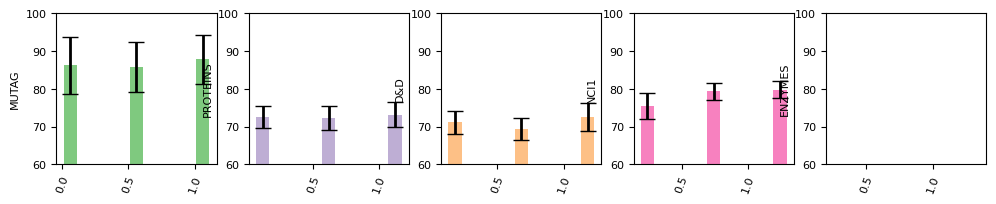

In [21]:

x_y_label_font = 8
def plot_bars(X, y, y_err=None, label="None", ax=None, colors=None, width=0.1):
    color = 'black'
    err_attr={"elinewidth":2,"ecolor":"black","capsize":6}
    if colors is None:
         colors = ['#F9DA4A','#96DB35', '#66C2A5','#81B0D3','#EF8C61']
         
    ax.bar(X, y, yerr=y_err, error_kw=err_attr, color = colors,
            width=width, label=names)
    # ax.bar(X, y, color = colors,
    #          width=width, tick_label=label)
    
    ax.set_ylabel(label, color=color, fontsize=x_y_label_font)
    
     # fontsize=15, fontweight='bold')
    ax.tick_params(axis='y', labelcolor=color, labelsize=x_y_label_font)
    ax.tick_params(axis='x', rotation=70, labelsize=x_y_label_font)
    ax.set_ylim(60, 100)
    # ax.legend(names)
    

X = np.linspace(0, 1, 3)
color = MyColor('Accent', skip_idx=3, backup_name='Set1', backup_color=7)
fig, axs = plt.subplots(nrows=1,ncols=len(show_data), figsize=(12, 2), dpi=100)
for ax, name in zip(axs, show_data):
    y = [i[0] for i in results[name]]
    std = [i[1] for i in results[name]]
    X += 0.06
    colr = color.get_color()
    colors = [colr for _ in range(len(y))]
    plot_bars(X, y, y_err=std, label=name, ax=ax, colors=colors)


plt.show()
# handles, labels = ax1.get_legend_handles_labels()
# bbox_to_anchors=(0.5, -0.08)
# fig.legend(handles, labels, frameon=False, ncol=9, fontsize=x_y_legend_font, bbox_to_anchor=bbox_to_anchors, loc='lower center')